In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import pickle
import re
# from tensorflow_core.python.ops import math_ops
from urllib.request import urlretrieve
from os.path import isfile, isdir
import seaborn as sns

In [2]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')

## 数据分布趋势查看

In [3]:
#用户信息无空值
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   UserID        6040 non-null   int64 
 1   Gender        6040 non-null   object
 2   Age           6040 non-null   int64 
 3   OccupationID  6040 non-null   int64 
 4   Zip-code      6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


## 年龄分布

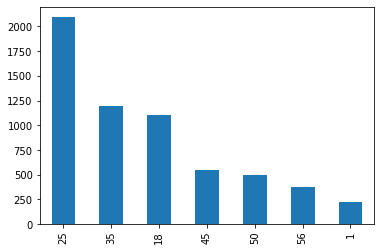

In [4]:
users.Age.value_counts().plot(kind = 'bar')

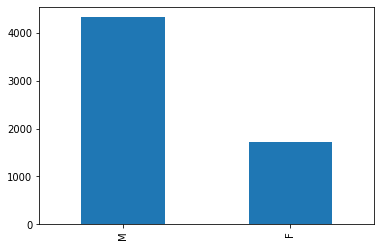

In [5]:
users.Gender.value_counts().plot(kind = 'bar')

## 电影特征分析

In [6]:
# 按照某一列展开
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [7]:
movies.Genres = movies.Genres.str.split('|')
movies = explode(movies, ['Genres'])
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation
1,1,Toy Story (1995),Children's
2,1,Toy Story (1995),Comedy
3,2,Jumanji (1995),Adventure
4,2,Jumanji (1995),Children's


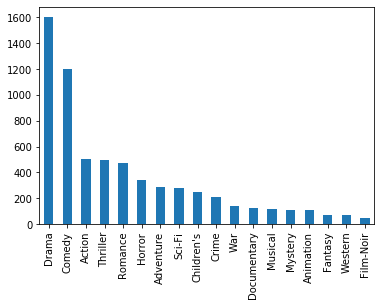

In [8]:
movies.Genres.value_counts().plot(kind = 'bar')

## 结论：可以考虑将评论电影风格少的电影集进行删除

## 用户电影评分分析

In [9]:
import time
ratings['timestamps'] = ratings['timestamps'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,2001
1,1,661,3,2001
2,1,914,3,2001
3,1,3408,4,2001
4,1,2355,5,2001


In [10]:
# movies = movies.drop('Title', axis=1)
# movies.head()

In [11]:
ratings = ratings.merge(movies, left_on='MovieID', right_on='MovieID', how='inner')
ratings.head()

,UserID,MovieID,Rating,timestamps,Title,Genres
0,1,1193,5,2001,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,2001,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,2000,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,2000,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,2000,One Flew Over the Cuckoo's Nest (1975),Drama


In [12]:
ratings.shape

(2101815, 6)

In [13]:
# 提取电影风格类型大于100的电影
movie_count=movies.Genres.value_counts()
movie_count[movie_count>100].index
ratings = ratings.loc[ratings['Genres'].isin(movie_count[movie_count>100].index)]


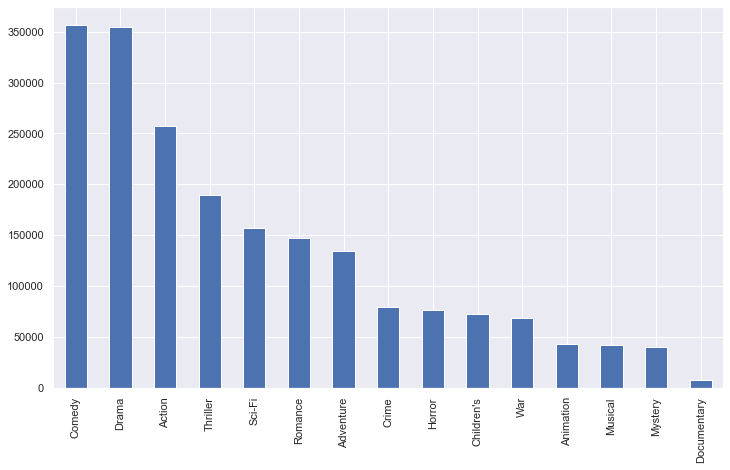

In [17]:
#movie_ratings.groupby(['Genres'],as_index=False)['MovieID'].count.sort_values( by['MovieID'],ascending=0)
ratings.Genres.value_counts().plot(kind = 'bar')

## 查看不同年份，不同电影风格，评分情况
- 按'movieId','year','genres'进行分组，并计算各组平均值

In [15]:
mg_ratings = ratings.groupby(['MovieID', 'timestamps', 'Genres'], as_index=False)['Rating'].aggregate(np.mean)
mg_ratings.rename(columns={'timestamps':'year'},inplace=True)
mg_ratings.head()

,MovieID,year,Genres,Rating
0,1,2000,Animation,4.146924
1,1,2000,Children's,4.146924
2,1,2000,Comedy,4.146924
3,1,2001,Animation,4.131868
4,1,2001,Children's,4.131868


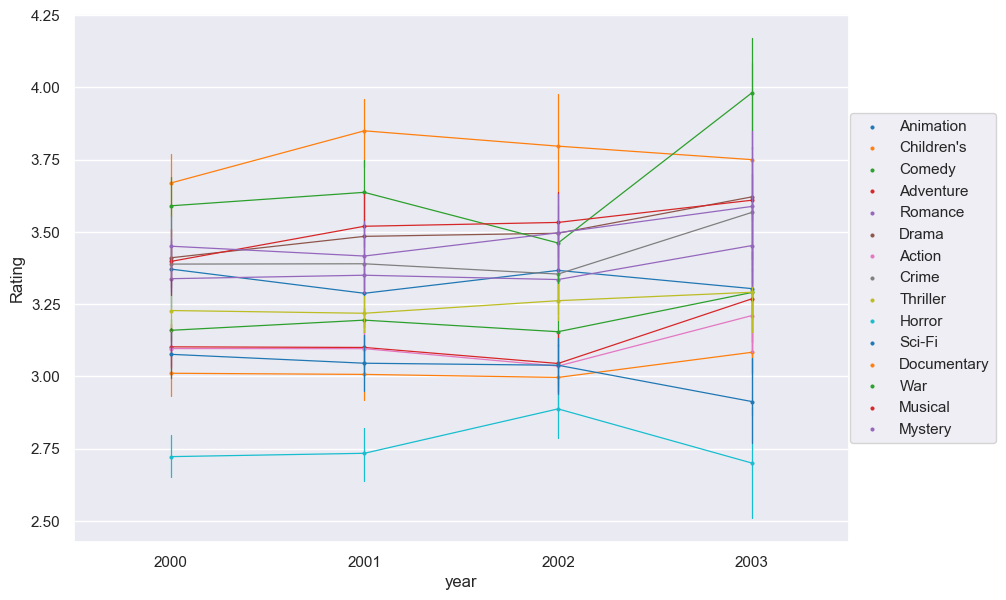

In [47]:
# 设置像素
plt.figure(dpi=100)
sns.set(font_scale=1,rc={'lines.linewidth':0.5,'figure.figsize':(10,7)})
sns.pointplot(x='year',y='Rating',hue='Genres',data=mg_ratings,palette='tab10')
plt.legend(loc='right',bbox_to_anchor=(1.2,0.5))#图示靠右显示


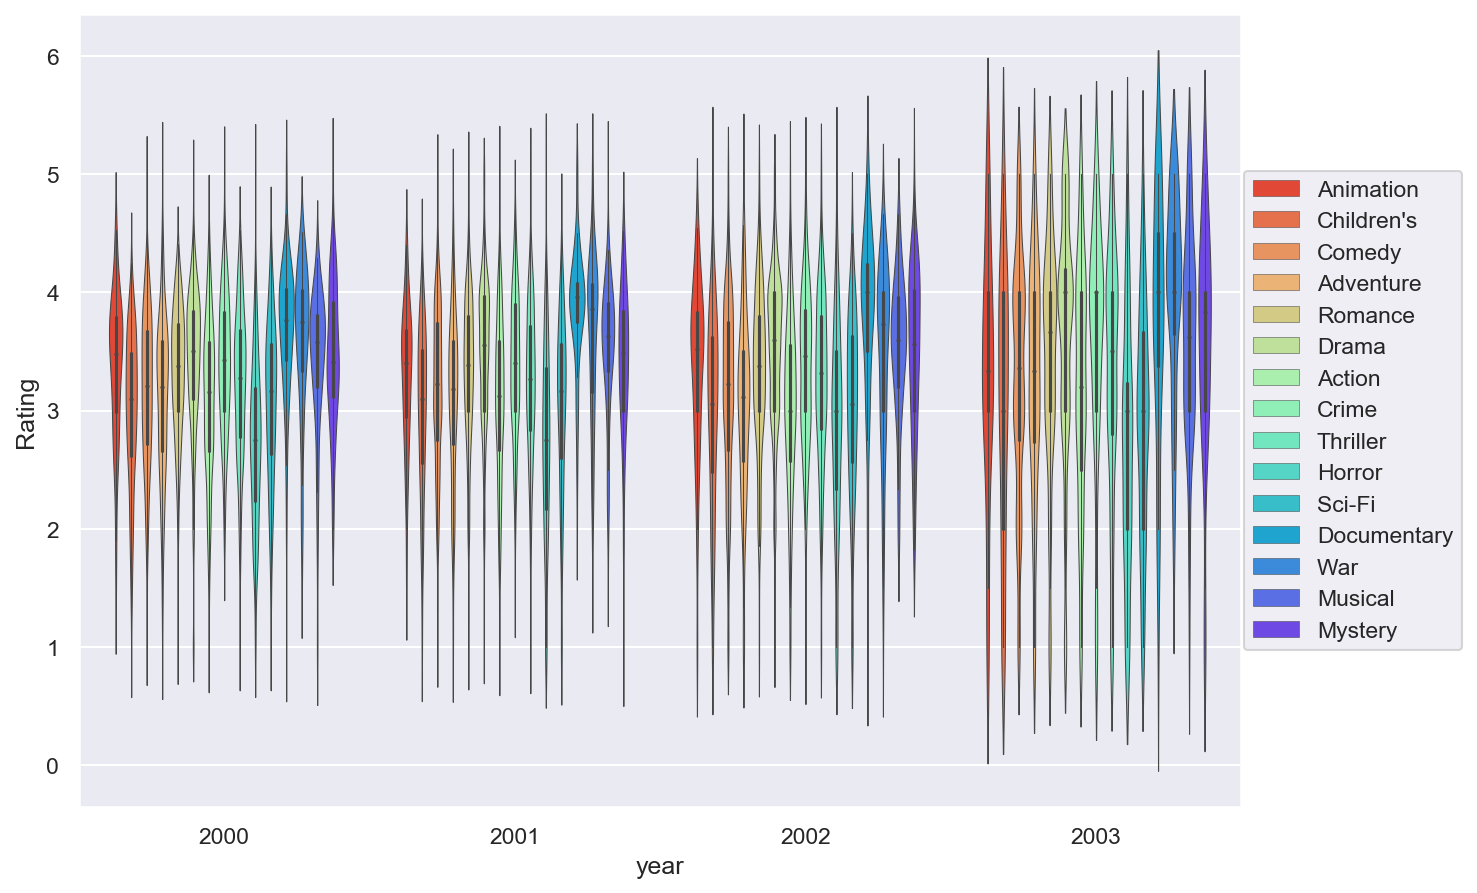

In [24]:
#小提琴图 查看某种风格电影评分分布
plt.figure(dpi=150)
sns.set(font_scale=1,rc={'lines.linewidth':0.5})
sns.violinplot(x='year',y='Rating',hue='Genres',data=mg_ratings,palette='rainbow_r') 
plt.legend(bbox_to_anchor=(1.2,0.5),loc=7)

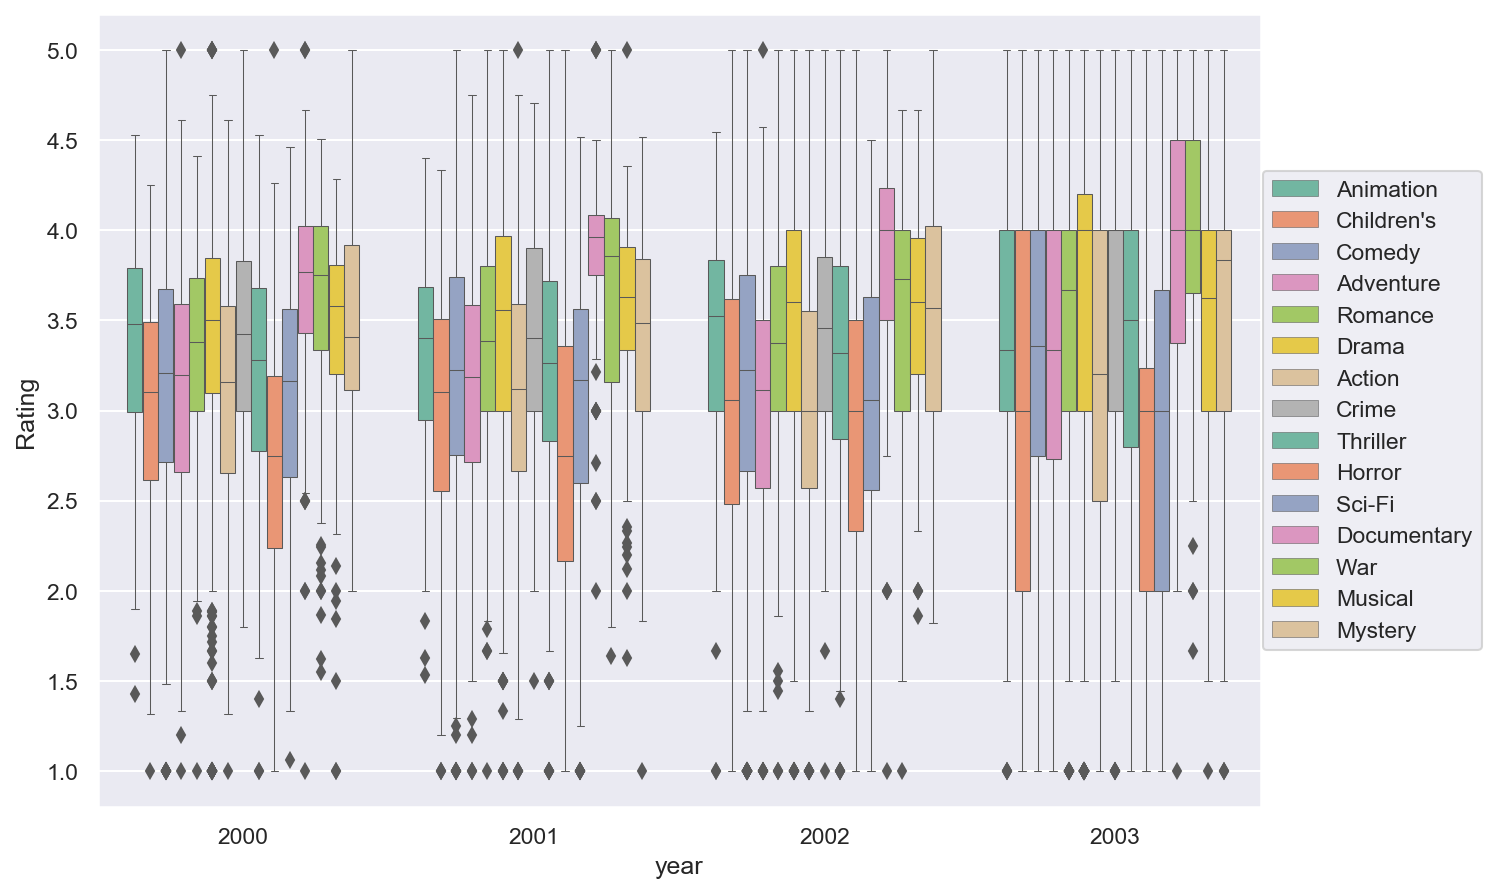

In [25]:
#箱线图 查看某种风格电影评分分布
plt.figure(dpi=150)
sns.set(font_scale=1,rc={'lines.linewidth':0.5})
sns.boxplot(x='year',y='Rating',hue='Genres',data=mg_ratings,palette='Set2')
plt.legend(bbox_to_anchor=(1.2,0.5),loc=7)


In [26]:
ratings

,UserID,MovieID,Rating,timestamps,Title,Genres
0,1,1193,5,2001,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,2001,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,2000,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,2000,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,2000,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
2101809,5675,2703,3,2000,Broken Vessels (1998),Drama
2101810,5780,2845,1,2000,White Boys (1999),Drama
2101811,5851,3607,5,2000,One Little Indian (1973),Comedy
2101812,5851,3607,5,2000,One Little Indian (1973),Drama


## 关联程度分析
- 根据 'userId','genres'进行分组，并计算每组平均分

In [30]:
ug_ratings=ratings.groupby(['UserID','Genres'],as_index=False)['Rating'].aggregate(np.mean)
ug_ratings.head()

,UserID,Genres,Rating
0,1,Action,4.200000
1,1,Adventure,4.000000
2,1,Animation,4.111111
3,1,Children's,4.250000
4,1,Comedy,4.142857


<Figure size 1500x1050 with 0 Axes>

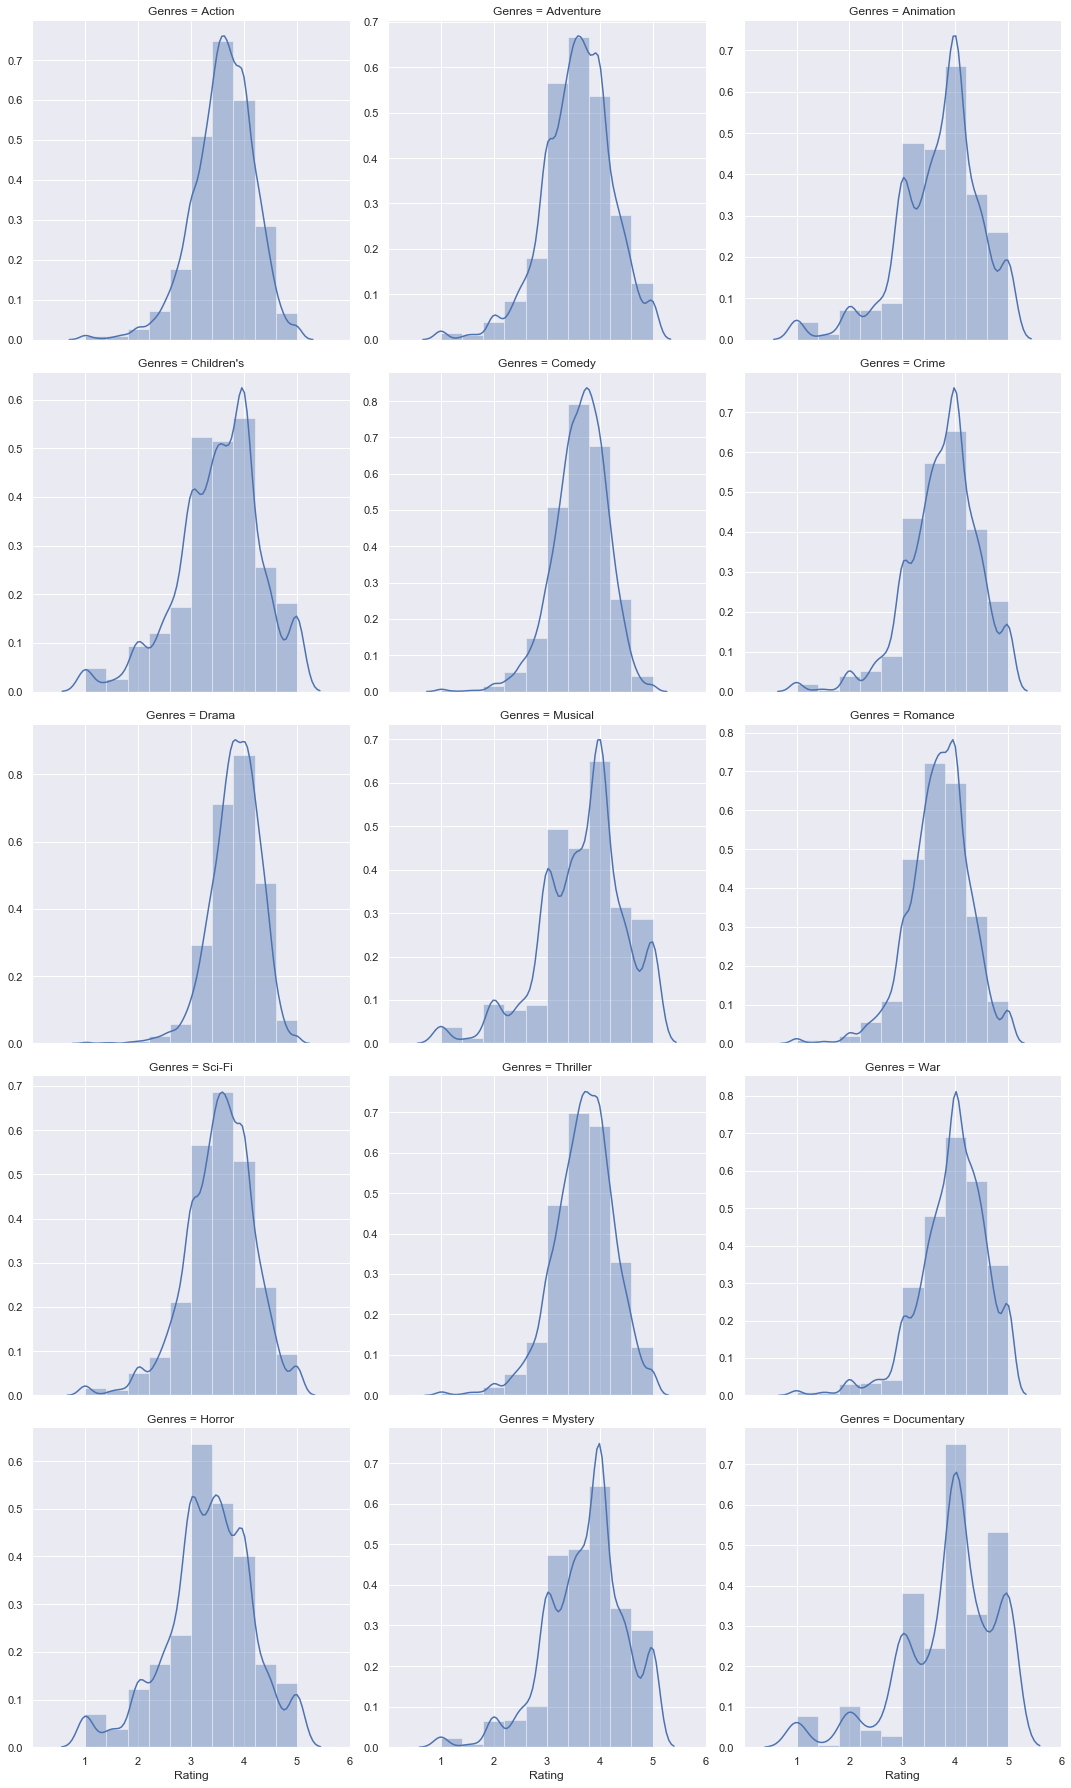

In [60]:
plt.figure(dpi=150)
sns.set(style='darkgrid')
sns.set(font_scale=1)
g=sns.FacetGrid(ug_ratings,col='Genres',sharey=False,height=5,col_wrap =3)
g.map(sns.distplot,'Rating',bins=10).set(xlim=(0,6),xticks=[1,2,3,4,5,6])

In [51]:
ug_ratings

,UserID,Genres,Rating
0,1,Action,4.200000
1,1,Adventure,4.000000
2,1,Animation,4.111111
3,1,Children's,4.250000
4,1,Comedy,4.142857
...,...,...,...
80782,6040,Mystery,4.454545
80783,6040,Romance,3.488889
80784,6040,Sci-Fi,3.473684
80785,6040,Thriller,3.926829


## 通过关联图分析关联程度


In [53]:
pivot=ug_ratings.pivot(index='UserID',columns='Genres',values='Rating') 
pivot.head()

Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War
UserID,,,,,,,,,,,,,,,
1,4.200000,4.000000,4.111111,4.250000,4.142857,4.000000,NaN,4.428571,NaN,4.285714,NaN,3.666667,4.333333,3.666667,5.000000
2,3.500000,3.736842,NaN,NaN,3.560000,3.583333,NaN,3.898734,3.000000,NaN,3.333333,3.708333,3.588235,3.483871,3.733333
3,3.956522,4.000000,4.000000,4.000000,3.766667,NaN,NaN,4.000000,2.666667,4.000000,3.000000,3.800000,3.833333,3.800000,4.000000
4,4.157895,3.833333,NaN,4.000000,NaN,5.000000,NaN,4.166667,4.333333,NaN,NaN,4.000000,3.555556,3.500000,3.333333
5,2.612903,3.000000,4.000000,3.833333,3.410714,3.285714,3.666667,3.096154,2.800000,3.333333,3.125000,3.100000,3.066667,2.846154,3.500000


<Figure size 1500x1050 with 0 Axes>

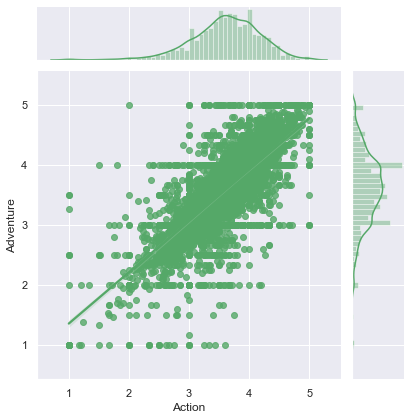

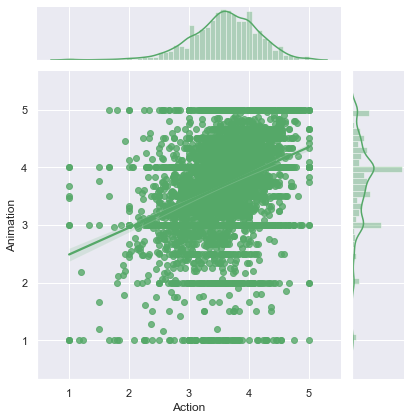

In [61]:
# - 绘制Comedy,Adventure两种类型电影评分的联合图，分析关联程度
plt.figure(dpi=150)
sns.jointplot('Action','Adventure',pivot,kind='reg',color='g')
sns.jointplot('Action','Animation',pivot,kind='reg',color='g')

In [56]:
ratings.corr()

,UserID,MovieID,Rating
UserID,1.000000,-0.015888,0.011643
MovieID,-0.015888,1.000000,-0.072102
Rating,0.011643,-0.072102,1.000000


In [57]:
ratings

,UserID,MovieID,Rating,timestamps,Title,Genres
0,1,1193,5,2001,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,2001,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,2000,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,2000,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,2000,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
2101809,5675,2703,3,2000,Broken Vessels (1998),Drama
2101810,5780,2845,1,2000,White Boys (1999),Drama
2101811,5851,3607,5,2000,One Little Indian (1973),Comedy
2101812,5851,3607,5,2000,One Little Indian (1973),Drama


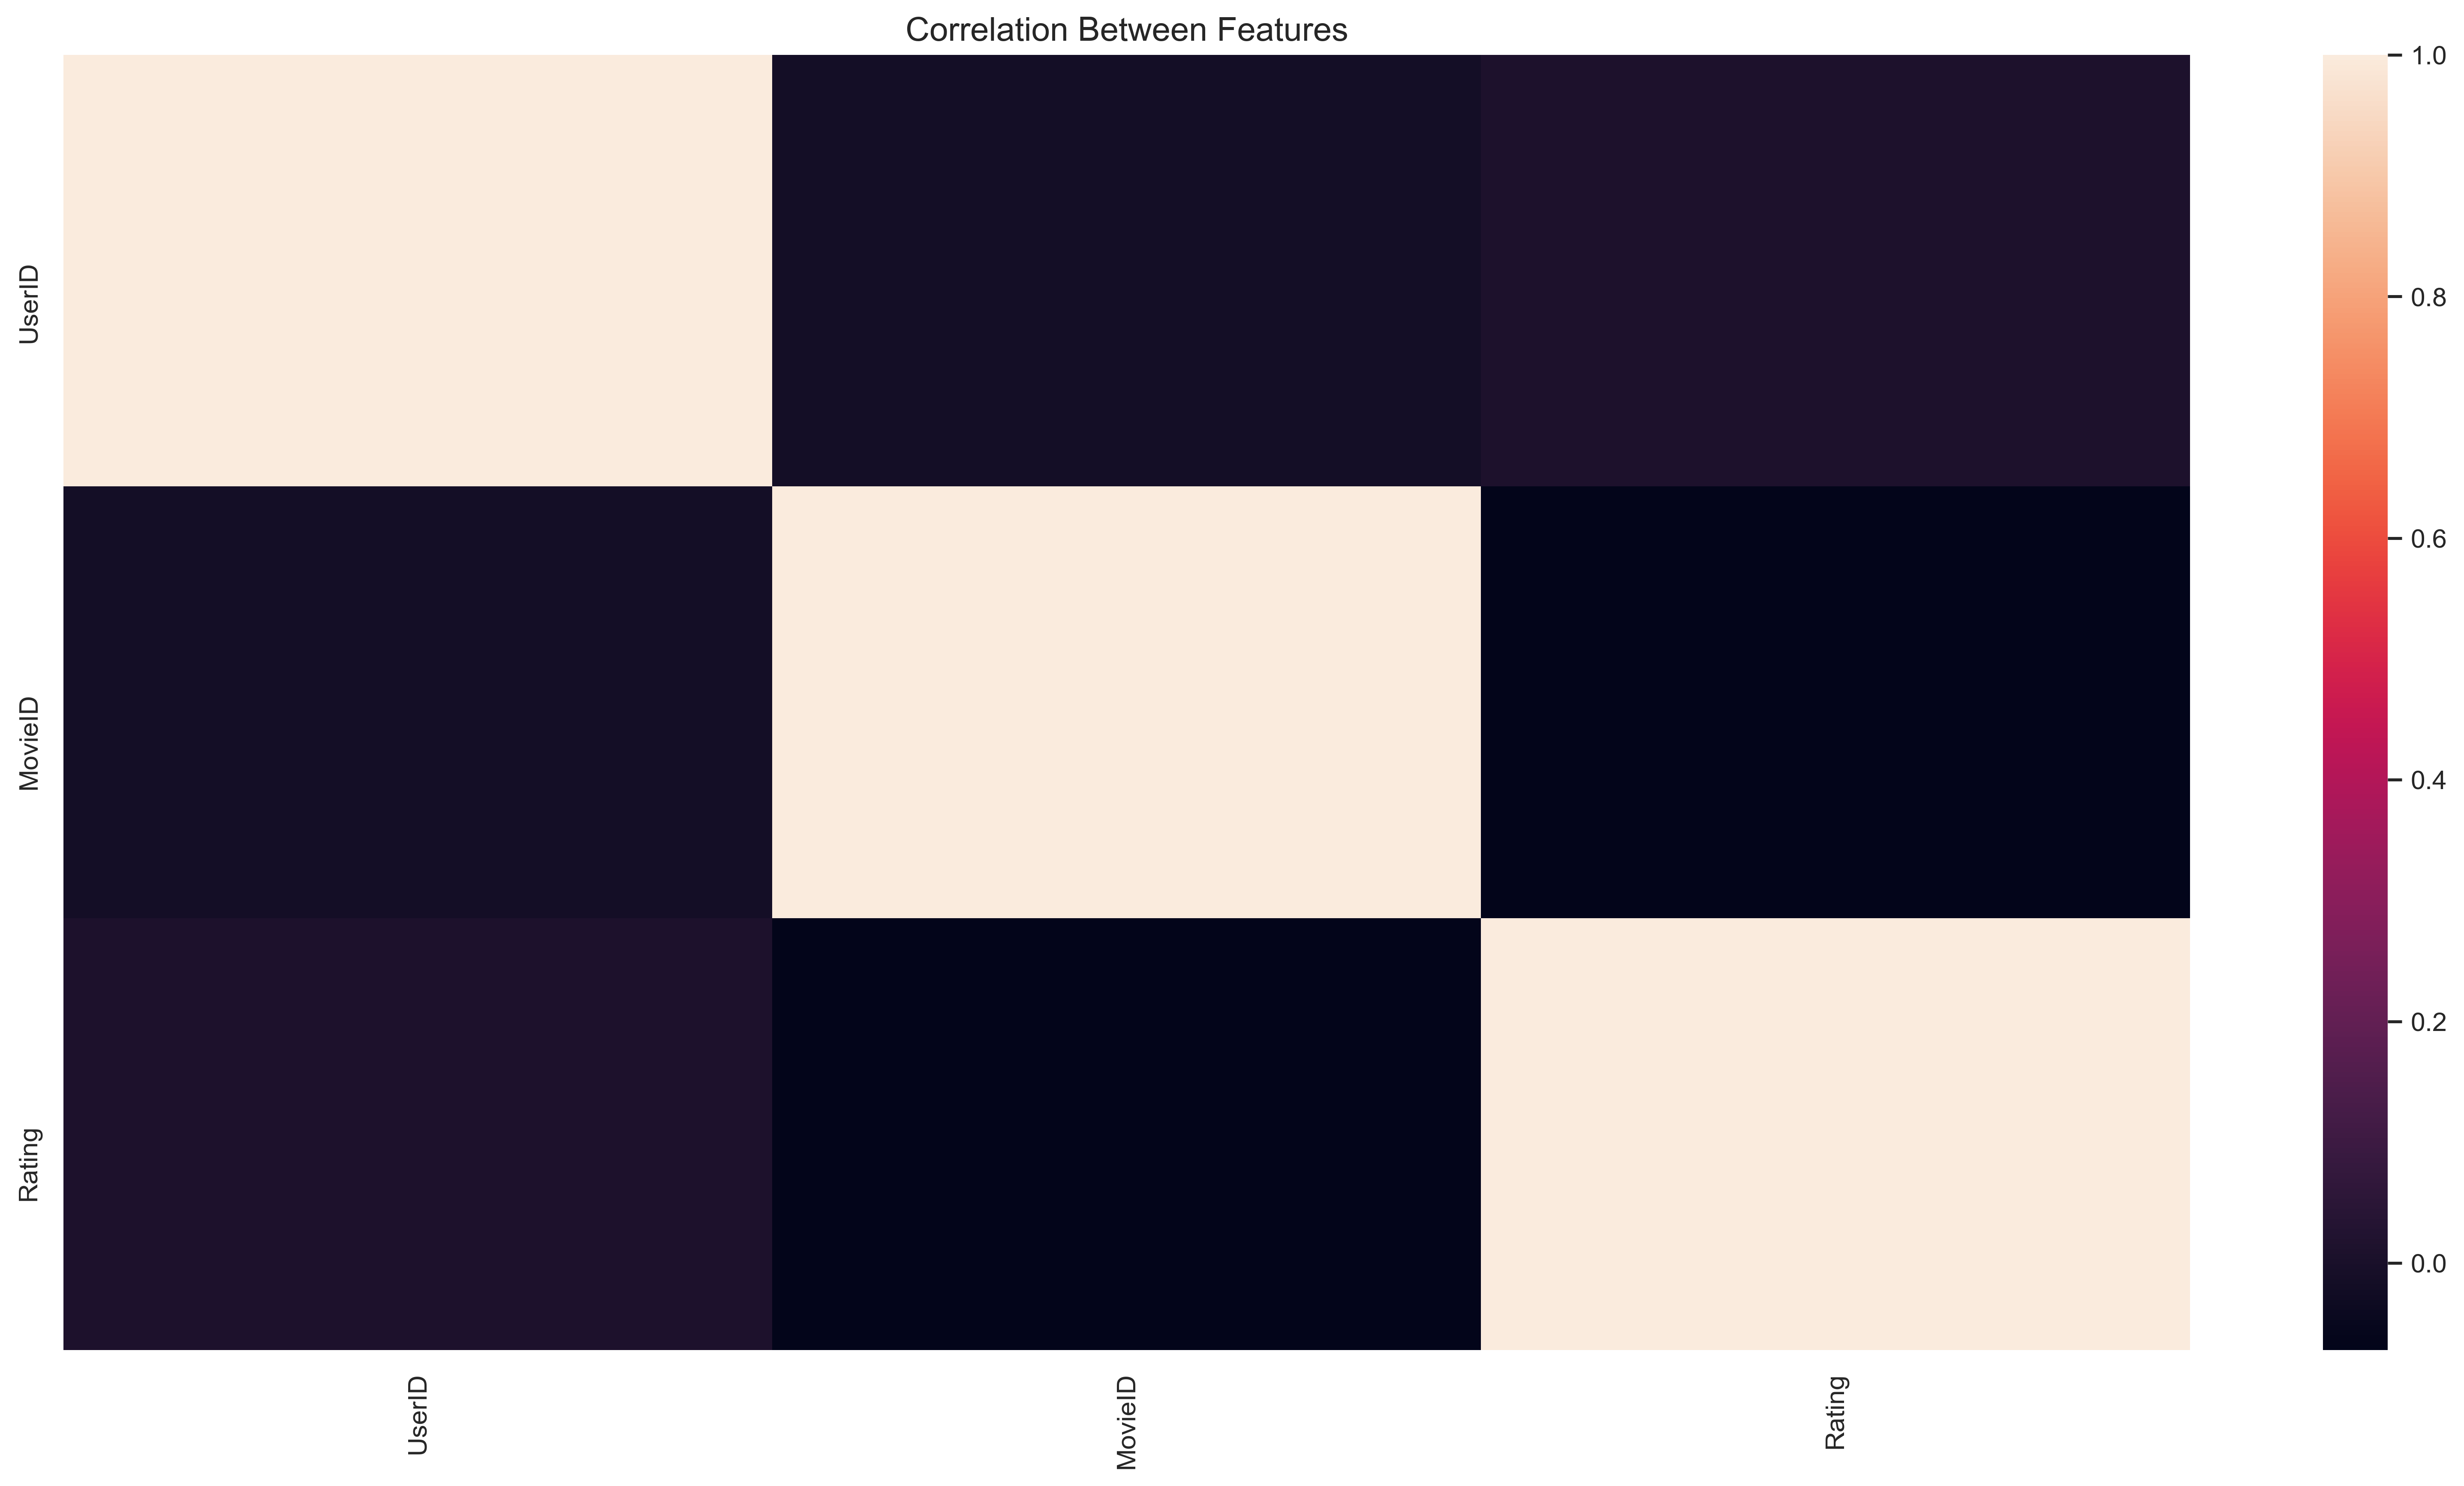

In [58]:
# visualize the correlation between remaining features
corr = ratings.corr()
plt.figure(figsize = (20,10), dpi= 400)
# 热力图 颜色越浅，相关系数越大
sns.heatmap(corr)
plt.title("Correlation Between Features", fontsize = 14)
plt.xticks(rotation = 'vertical')
# plt.savefig('correlation.jpg')
plt.show()